In [1]:
import os
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import data
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from  sklearn.metrics.pairwise import cosine_similarity
from random import sample

## Read and Split Data

In [2]:
data_path = "data/negotiate"
lines = []
file_name = os.path.join(data_path, 'data.txt')
with open(file_name, 'r') as f:
    for line in f:
        lines.append(line.strip())
g =  [line[:12] for line in lines]
o =  [line[-12:] for line in lines]
selection = [line[12:-12].split('<eos>')[-2].split('<selection>')[1] for line in lines]
rew = [line[12:-12].split('<eos>')[-1][8:] for line in lines]
dialog = [line[12:-12].split('<eos>')[:-2] for line in lines]

In [3]:
df = pd.DataFrame({'g':g, 'dialog':dialog, 'selection':selection, 'reward':rew, 'outcome':o})
df.head()

,g,dialog,selection,reward,outcome
0,1 0 4 2 1 2,[YOU: i would like 4 hats and you can have the...,item0=0 item1=4 item2=0,8 agree,1 4 4 1 1 2
1,1 4 4 1 1 2,[THEM: i would like 4 hats and you can have th...,item0=1 item1=0 item2=1,6 agree,1 0 4 2 1 2
2,1 6 3 0 2 2,[YOU: you can have all the hats if i get the b...,item0=1 item1=3 item2=2,10 disagree,1 2 3 2 2 1
3,1 10 3 0 1 0,[ YOU: hi i would like the book and ball and y...,item0=1 item1=0 item2=0,10 agree,1 2 3 2 1 2
4,1 2 3 2 1 2,[THEM: hi i would like the book and ball and y...,item0=0 item1=3 item2=1,8 agree,1 10 3 0 1 0


In [4]:
sents = []

for d in df['dialog']:
    for sent in d:
        if sent[:3] == 'YOU':
            sents.append(sent.split(':')[1].strip())

# Embedding and Dimension Reduction

In [5]:

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(sents, show_progress_bar=True)

Batches:   0%|          | 0/181 [00:00<?, ?it/s]

In [6]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

C:\Users\ravy\Anaconda3\envs\py30\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


# HDBScan Clustering

In [7]:
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

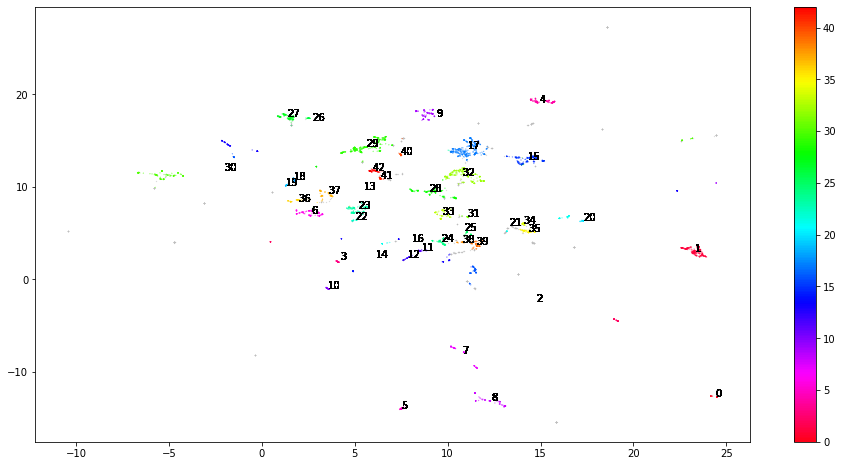

In [8]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

# Merge Similar Topics

In [9]:
docs_df = pd.DataFrame(sents, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sents))

In [11]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out ()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [12]:

n_merge = 20
for i in range(n_merge):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(sents)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)

# Re-plot Merged

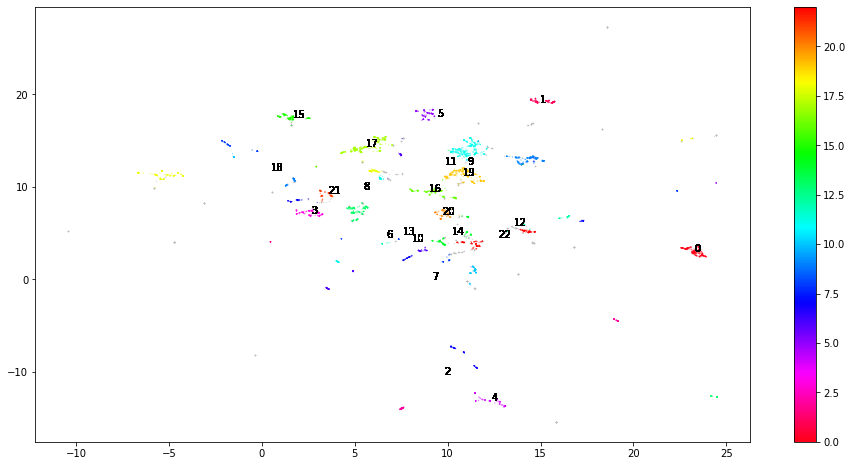

In [13]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = docs_df.Topic

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

# Cluster Distribution and Samples

In [14]:
topic_sizes.head(10)

,Topic,Size
0,-1,835
12,11,493
18,17,396
20,19,343
10,9,324
1,0,294
19,18,283
14,13,244
17,16,229
8,7,218


In [15]:
sent_df = pd.DataFrame({"text":sents, "cluster":cluster.labels_})

In [16]:
def get_examples(df, clusters,  n=10):
    examples = dict()
    for c in clusters:
        cluster_examples = list()
        cluster_examples.extend(sample(list(df[df['cluster'] == c].text),n))
        examples[c] = cluster_examples
    return examples

In [17]:
top_n = 20
examples = get_examples(sent_df, topic_sizes['Topic'][1:top_n+1])
print(f"Top {top_n} Largest Clusters: Random Example Messages")
for k in examples.keys():
    print("#"*30 + "\n")
    print(f"Sample messages for cluster {k}:\n")
    [print(m) for m in examples[k]]
    print("\n")

Top 20 Largest Clusters: Random Example Messages
##############################

Sample messages for cluster 11:

i need the hat and balls
i need the ball and hat
need hats
i need the hats and the ball .
i need the ball and the hat
i need the ball and the hats
the ball and the hats are what im in need of
i need the balls and the hat
i need the hat and balls
i need the hat and balls


##############################

Sample messages for cluster 17:

i would like 2 books and a hat and a ball .
i would like the 2 balls and 1 book
howdy could i have two balls and a book please
two books and a ball for me
can i get a ball two hats and a book ?
hey there , i'd like the two hats and either a book or a ball .
i want 1 book 2 hat take all my balls
i'd like 2 balls and 2 books please .
i'd like two balls and a book please kindly
i would like the ball and 1 hat and 2 books


##############################

Sample messages for cluster 19:

can i have the book annd a hat
can i have the book and a ha

In [18]:
print(f"Top {top_n} Largest Clusters: Key Terms (TFIDF)")
for i in topic_sizes['Topic'][1:top_n+1]:
    print("#"*30 + "\n")
    print(f"Top words for cluster {i}:\n")
    [print(m[0], ": ", m[1]) for m in top_n_words[i][:10]]
    print("\n")

Top 20 Largest Clusters: Key Terms (TFIDF)
##############################

Top words for cluster 11:

books :  0.1775222275506034
balls :  0.16796981340307615
ball :  0.15543995722964207
book :  0.13169844934345792
like :  0.12454195985844459
hats :  0.09828954096508605
hat :  0.09304821738810391
hello :  0.0667131258667928
want :  0.0615013887812006
hi :  0.0462774196166222


##############################

Top words for cluster 17:

book :  0.18404803571513362
balls :  0.17770380157616095
ball :  0.16383198284498843
ll :  0.1515228898070755
books :  0.14247290750788996
ill :  0.12714678707275417
hat :  0.12002042745986106
want :  0.10688876163553604
hats :  0.10051931697194665
need :  0.08528164098686228


##############################

Top words for cluster 19:

book :  0.30137224433112997
ball :  0.2182560492360596
hat :  0.19127597105391003
like :  0.10857094006018352
need :  0.08029628613333219
ll :  0.057009084742287115
want :  0.05006980481797051
balls :  0.04933667329894818
h